In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def plot_metrics_per_augmentation():
    base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'out'))
    metrics = ['loss', 'accuracy', 'recall', 'precision', 'f1']
    augment_keywords = ['blur', 'brightness', 'flip', 'noise', 'rotate']

    palette = sns.color_palette("Set2", len(metrics))

    for aug in augment_keywords:
        all_data = {metric: [] for metric in metrics}

        for folder in os.listdir(base_path):
            folder_path = os.path.join(base_path, folder)
            if not os.path.isdir(folder_path) or aug not in folder.lower():
                continue

            split_name = folder[-2:]  # ostatnie dwa znaki z nazwy folderu
            for fname in os.listdir(folder_path):
                if fname.endswith('test.csv'):
                    file_path = os.path.join(folder_path, fname)
                    try:
                        df = pd.read_csv(file_path)
                        for metric in metrics:
                            if metric in df.columns:
                                last_value = df[metric].dropna().iloc[-1]
                                all_data[metric].append({
                                    'split': split_name,
                                    'value': last_value
                                })
                    except Exception as e:
                        print(f"Błąd przy przetwarzaniu pliku {file_path}: {e}")

        # Rysowanie wykresu tylko jeśli coś zebrano
        if any(all_data[metric] for metric in metrics):
            fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 4), sharey=False)

            for i, metric in enumerate(metrics):
                df_metric = pd.DataFrame(all_data[metric])
                if not df_metric.empty:
                    sns.boxplot(x='split', y='value', data=df_metric, ax=axs[i], color=palette[i])
                    axs[i].set_title(metric.capitalize(), fontsize=12)
                    axs[i].set_xlabel('Splits')
                    axs[i].tick_params(axis='x')
                else:
                    axs[i].set_visible(False)

            plt.tight_layout()
            plt.suptitle(f"Wyniki na zbiorze testowym ({aug.capitalize()})", fontsize=16, y=1.05)
            plt.show()

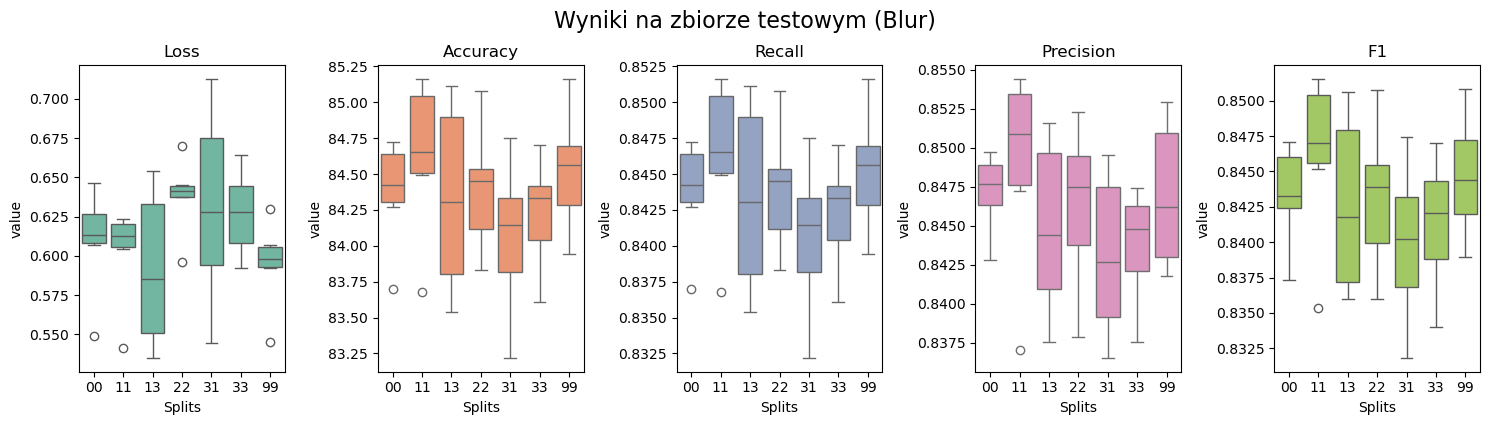

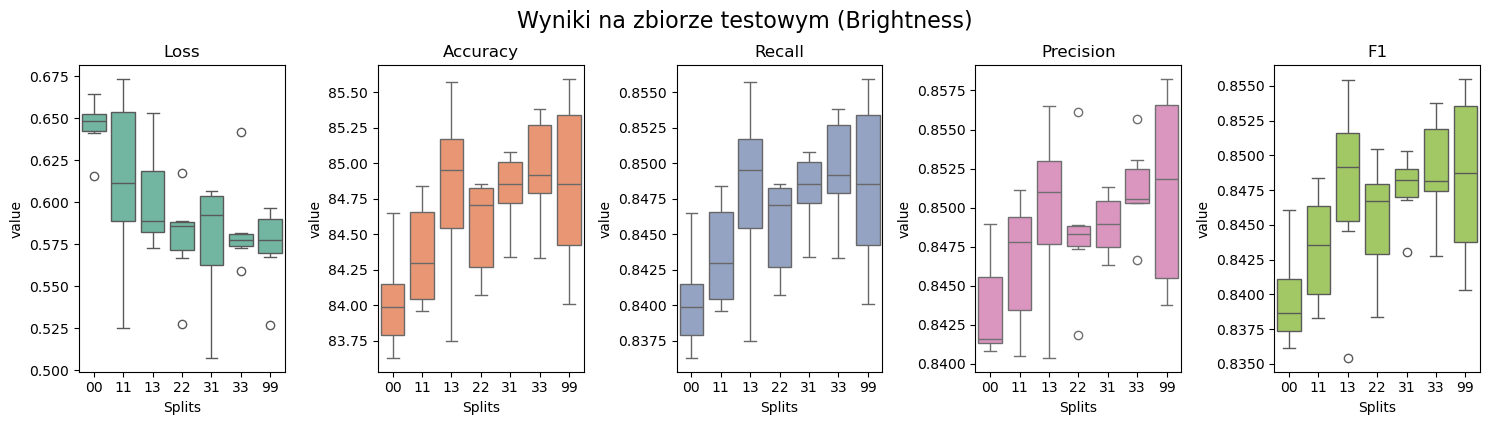

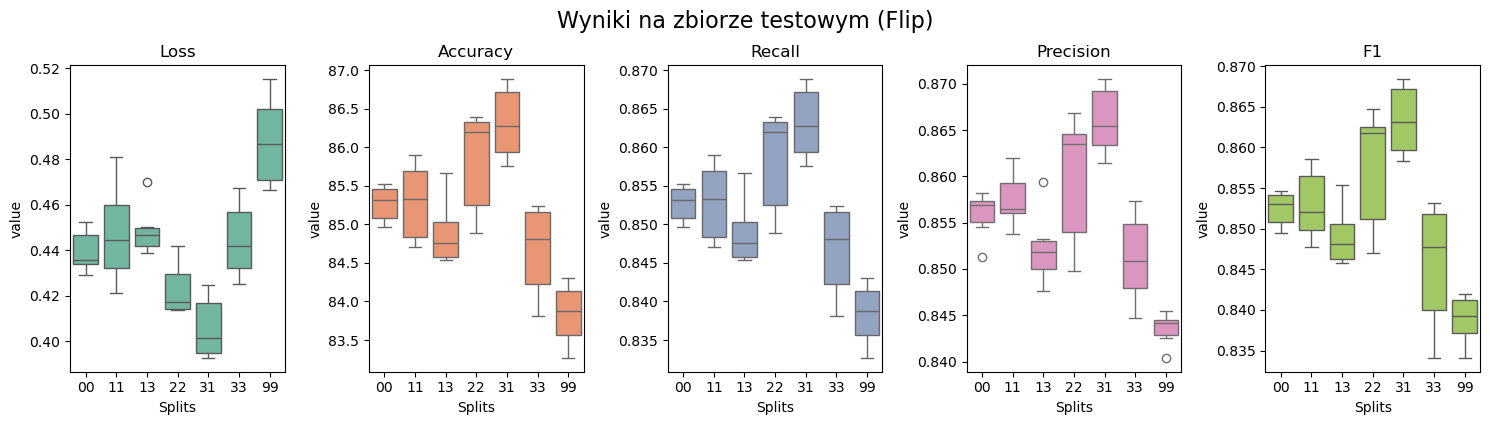

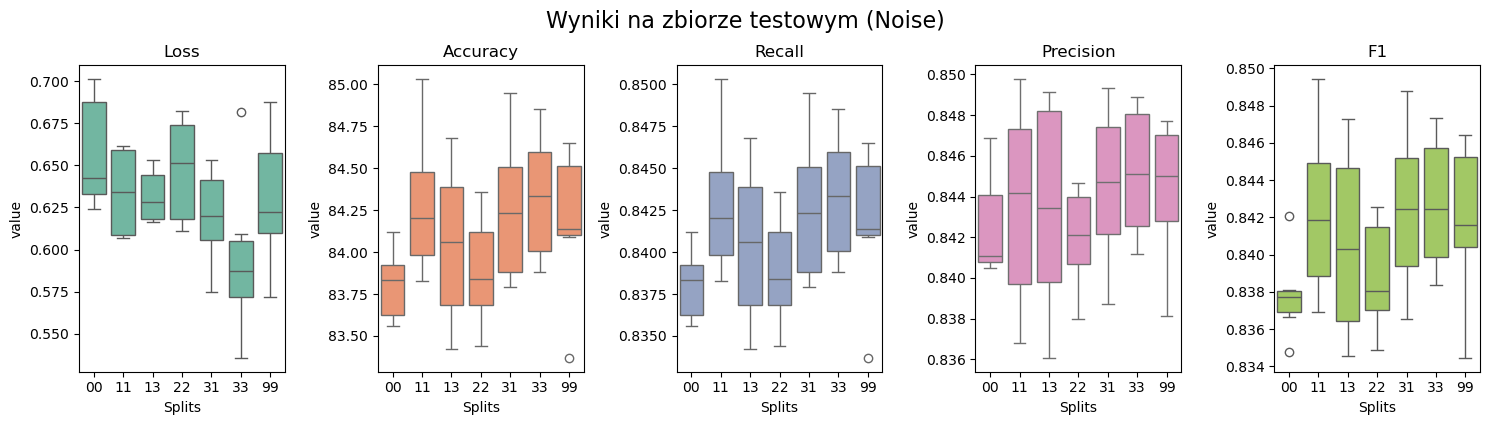

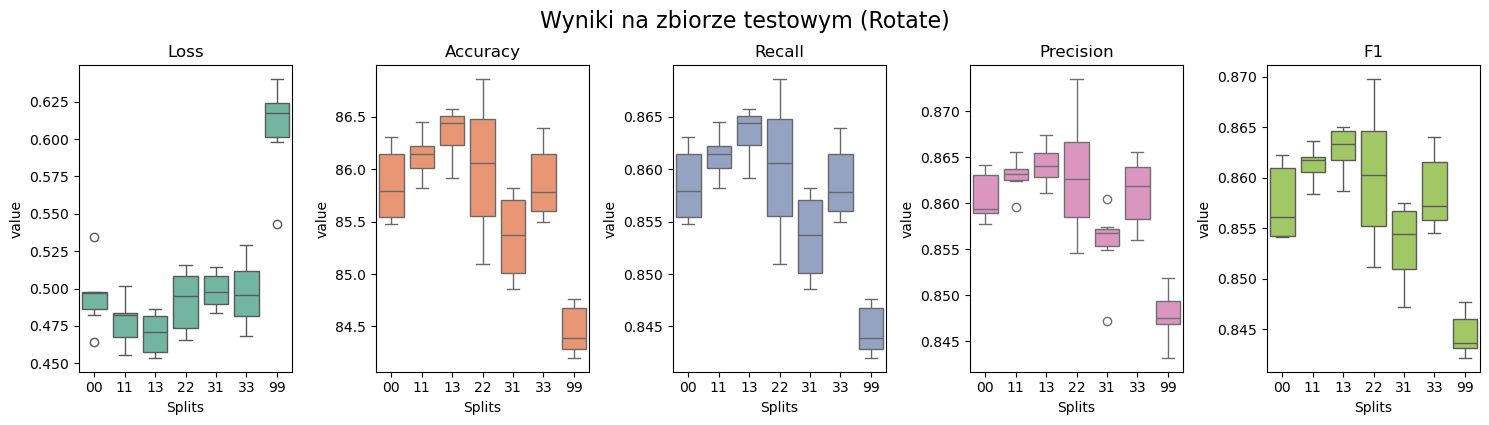

In [40]:
plot_metrics_per_augmentation()

In [4]:
def get_best_avg_dfs_for_all_augmentations():
    base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'out'))
    augment_keywords = ['blur', 'brightness', 'flip', 'rotate', 'noise']

    best_dfs = {}

    for augmentation_keyword in augment_keywords:
        test_avg_per_folder = {}
        val_data_per_folder = {}

        for folder in os.listdir(base_path):
            if augmentation_keyword not in folder.lower():
                continue

            folder_path = os.path.join(base_path, folder)
            if not os.path.isdir(folder_path):
                continue

            test_dfs = []
            val_dfs = []

            for fname in os.listdir(folder_path):
                if fname.endswith('test.csv'):
                    base_name = fname.replace('test.csv', '')
                    val_name = base_name + 'val.csv'
                    test_path = os.path.join(folder_path, fname)
                    val_path = os.path.join(folder_path, val_name)

                    try:
                        df_test = pd.read_csv(test_path)
                        test_dfs.append(df_test)

                        if os.path.exists(val_path):
                            df_val = pd.read_csv(val_path)
                            val_dfs.append(df_val)
                    except Exception as e:
                        print(f"Błąd podczas wczytywania {fname} w {folder}: {e}")

            if test_dfs and val_dfs:
                avg_test = pd.concat(test_dfs).groupby(level=0).mean().reset_index(drop=True)
                avg_val = pd.concat(val_dfs).groupby(level=0).mean().reset_index(drop=True)
                test_avg_per_folder[folder] = avg_test
                val_data_per_folder[folder] = avg_val

        if test_avg_per_folder:
            best_folder = max(test_avg_per_folder.items(), key=lambda x: x[1]['accuracy'].iloc[-1])[0]
            best_val_df = val_data_per_folder[best_folder]
            print(f"Wybrano folder: {best_folder} dla augmentacji '{augmentation_keyword}' z accuracy (test) = {test_avg_per_folder[best_folder]['accuracy'].iloc[-1]:.4f}")
            best_dfs[augmentation_keyword] = best_val_df
        else:
            print(f"Brak danych dla augmentacji: {augmentation_keyword}")
            best_dfs[augmentation_keyword] = None

    # Obsługa baseline i stes – analogicznie

    def handle_special_case(keyword):
        dfs_test = []
        dfs_val = []
        for folder in os.listdir(base_path):
            if keyword not in folder.lower():
                continue

            folder_path = os.path.join(base_path, folder)
            if not os.path.isdir(folder_path):
                continue

            for fname in os.listdir(folder_path):
                if fname.endswith('test.csv'):
                    base_name = fname.replace('test.csv', '')
                    val_name = base_name + 'val.csv'
                    test_path = os.path.join(folder_path, fname)
                    val_path = os.path.join(folder_path, val_name)

                    try:
                        df_test = pd.read_csv(test_path)
                        dfs_test.append(df_test)

                        if os.path.exists(val_path):
                            df_val = pd.read_csv(val_path)
                            dfs_val.append(df_val)
                    except Exception as e:
                        print(f"Błąd podczas wczytywania {fname} w {folder}: {e}")

        if dfs_test and dfs_val:
            avg_test = pd.concat(dfs_test).groupby(level=0).mean().reset_index(drop=True)
            avg_val = pd.concat(dfs_val).groupby(level=0).mean().reset_index(drop=True)
            print(f"Obliczono średnią dla {keyword} z accuracy (test) = {avg_test['accuracy'].iloc[-1]:.4f}")
            return avg_val
        else:
            print(f"Brak danych dla {keyword}.")
            return None

    best_dfs['baseline'] = handle_special_case('baseline')
    best_dfs['stes'] = handle_special_case('stes')

    return best_dfs

In [5]:
best_dfs = get_best_avg_dfs_for_all_augmentations()

Wybrano folder: blur_11 dla augmentacji 'blur' z accuracy (test) = 84.6300
Wybrano folder: brightness_33 dla augmentacji 'brightness' z accuracy (test) = 84.9450
Wybrano folder: flip_31 dla augmentacji 'flip' z accuracy (test) = 86.3150
Wybrano folder: rotate_13 dla augmentacji 'rotate' z accuracy (test) = 86.3450
Wybrano folder: noise_33 dla augmentacji 'noise' z accuracy (test) = 84.3300
Obliczono średnią dla baseline z accuracy (test) = 84.0950
Obliczono średnią dla stes z accuracy (test) = 86.4000


In [6]:
def plot_all_metrics_subplots(best_dfs):
    metrics = ['loss', 'accuracy', 'recall', 'precision', 'f1']
    augmentations = ['baseline', 'stes', 'blur', 'brightness', 'flip', 'rotate', 'noise']
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'gray', 'olive']

    fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharex=True)

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for j, aug in enumerate(augmentations):
            df = best_dfs.get(aug)
            if df is not None and metric in df.columns:
                ax.plot(df[metric], label=aug, color=colors[j % len(colors)])
        
        ax.set_title(metric.capitalize())
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.grid(True)
        ax.legend()

    fig.suptitle('Wykresy metryk dla najlepszych podziałów zdjęć (na zbiorze walidacyjnym)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

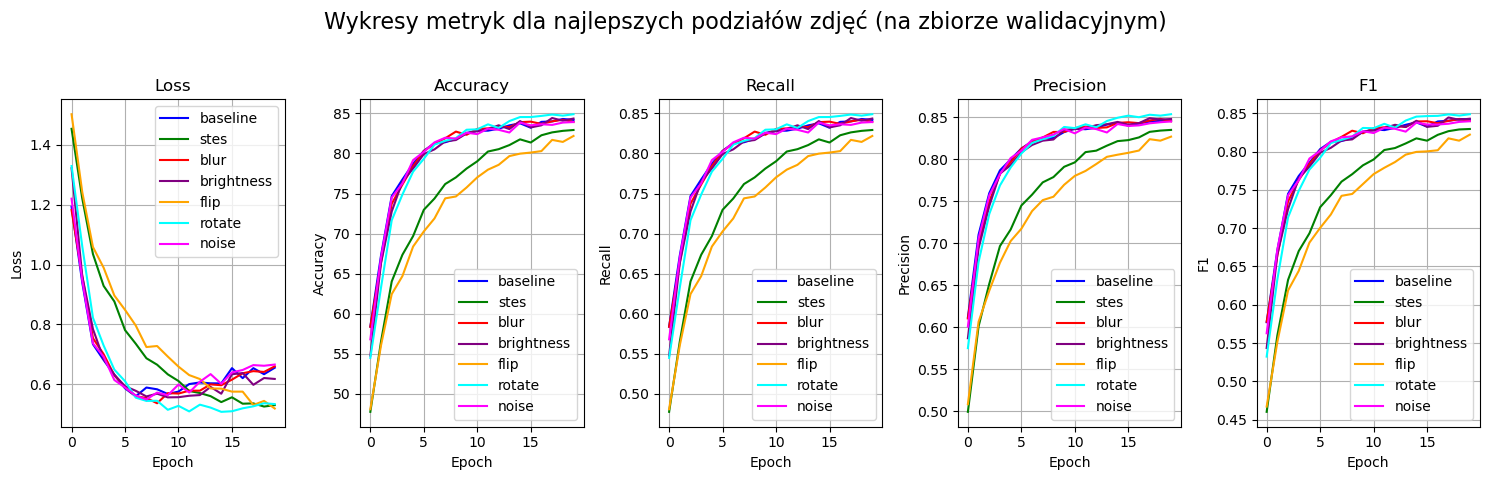

In [7]:
plot_all_metrics_subplots(best_dfs)